<p align="center">
  <img src="https://www.centralesupelec.fr/sites/all/themes/cs_theme/medias/common/images/intro/logo.png" alt="Logo 2" width="600" style="margin-left: 20px;"/>
</p>

# NLP Kaggle CS 2025 

# 1. Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os
import random
from collections import Counter
import random
import re
import unicodedata

In [10]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

Utilisation de: cpu


# 2. Data exploration

In [11]:
df = pd.read_csv("data/train_submission.csv")

print(df.head())
print(df.info())
print(df["Label"].value_counts().head(10))  

    Usage                                               Text Label
0  Public  َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...   hau
1  Public  Filmen forteller historien om Will Hunting  en...   nob
2  Public  An Arthrostylidium berryi in uska species han ...   wln
3  Public  Kancunarí enemigosniyquichejta munacuychej  al...   quh
4  Public  Warmeqa ama yachachichunchu hermanospa tantaku...   quh
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190599 entries, 0 to 190598
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Usage   190599 non-null  object
 1   Text    190599 non-null  object
 2   Label   190099 non-null  object
dtypes: object(3)
memory usage: 4.4+ MB
None
Label
tgk    1500
kur    1000
hin    1000
aze    1000
bak    1000
kat    1000
srp    1000
hbs    1000
uig    1000
hau    1000
Name: count, dtype: int64


In [12]:
# Statistiques descriptives sur la colonne de texte (par exemple "Text")
df["Text_length"] = df["Text"].apply(lambda x: len(str(x).split()))

stats = df["Text_length"].describe()
mean = stats["mean"] 
std = stats["std"]  
median = np.median(df["Text_length"])  
min_val = stats["min"]  
max_val = stats["max"] 
q25 = stats["25%"]  
q50 = stats["50%"]  
q75 = stats["75%"]  

se = std / np.sqrt(len(df["Text_length"]))

print("Statistiques descriptives complètes pour la longueur des textes :")
print(f"Moyenne : {mean}")
print(f"Écart-type : {std}")
print(f"Médiane : {median}")
print(f"Min : {min_val}")
print(f"Max : {max_val}")
print(f"25ème percentile : {q25}")
print(f"50ème percentile (Médiane) : {q50}")
print(f"75ème percentile : {q75}")
print(f"Erreur standard (SE) : {se}")

print("\nStatistiques de base :")
print(df["Text_length"].describe())

Statistiques descriptives complètes pour la longueur des textes :
Moyenne : 23.79271664594253
Écart-type : 57.63516046921473
Médiane : 16.0
Min : 1.0
Max : 11557.0
25ème percentile : 10.0
50ème percentile (Médiane) : 16.0
75ème percentile : 27.0
Erreur standard (SE) : 0.13201619090873035

Statistiques de base :
count    190599.000000
mean         23.792717
std          57.635160
min           1.000000
25%          10.000000
50%          16.000000
75%          27.000000
max       11557.000000
Name: Text_length, dtype: float64


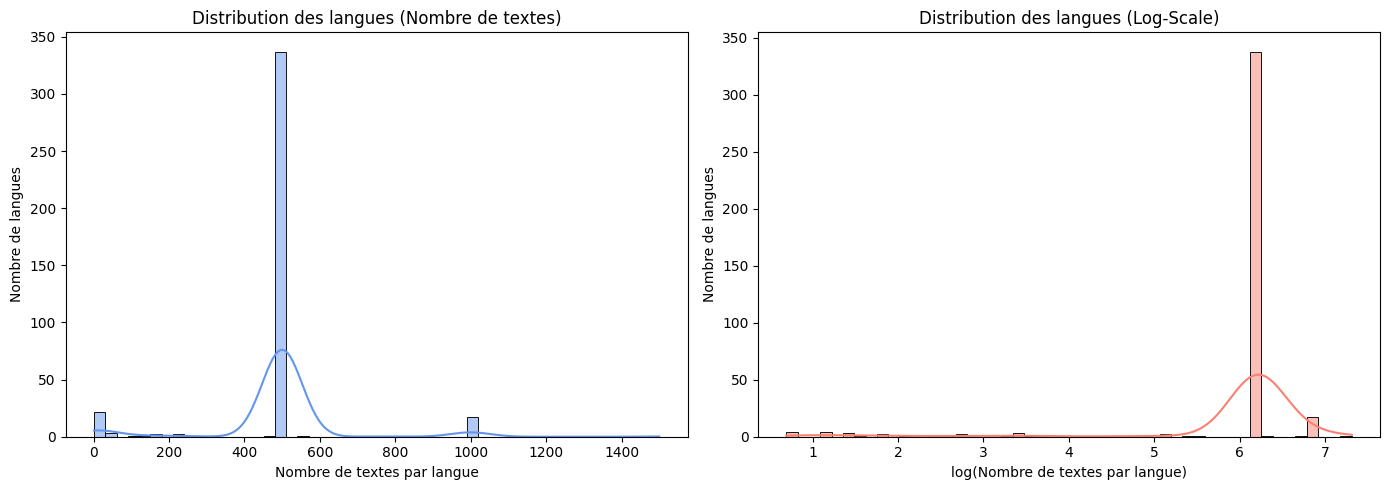

In [13]:
lang_counts = df["Label"].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(lang_counts, bins=50, kde=True, ax=axes[0], color="cornflowerblue")
axes[0].set_title("Distribution des langues (Nombre de textes)")
axes[0].set_xlabel("Nombre de textes par langue")
axes[0].set_ylabel("Nombre de langues")

sns.histplot(np.log1p(lang_counts), bins=50, kde=True, ax=axes[1], color="salmon")
axes[1].set_title("Distribution des langues (Log-Scale)")
axes[1].set_xlabel("log(Nombre de textes par langue)")
axes[1].set_ylabel("Nombre de langues")

plt.tight_layout()
plt.show()

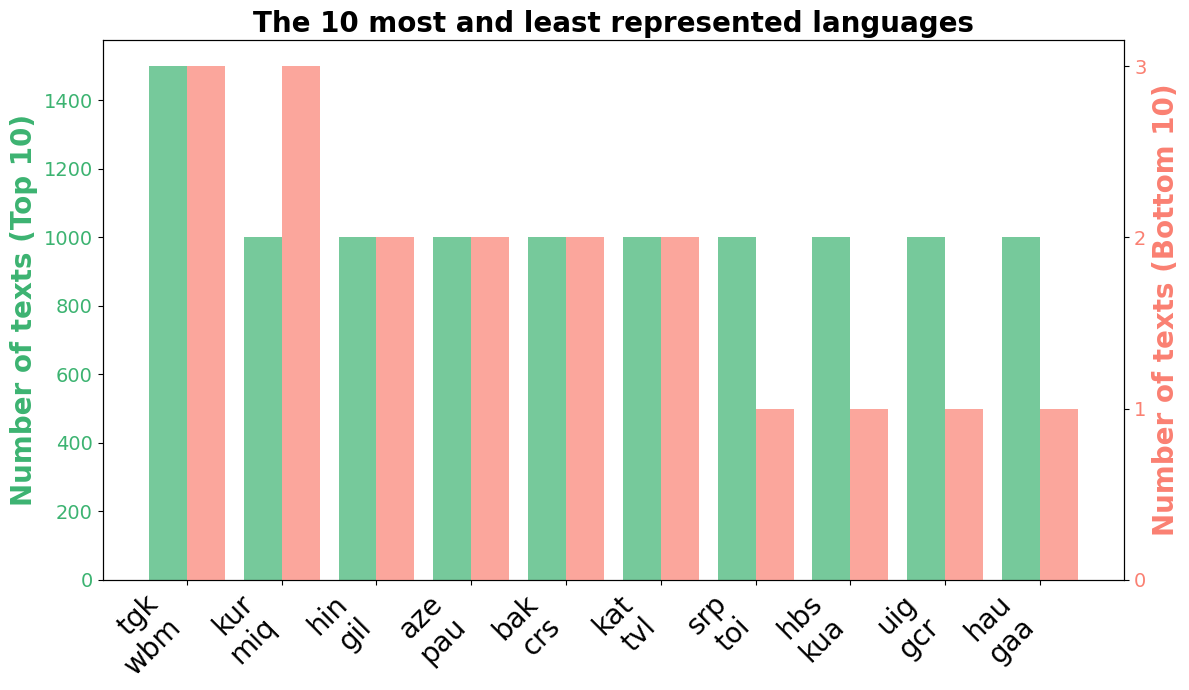

In [14]:
import numpy as np
import matplotlib.pyplot as plt

top_10 = lang_counts.head(10)
bottom_10 = lang_counts.tail(10)

lang_labels = [f"{top}\n{bottom}" for top, bottom in zip(top_10.index, bottom_10.index)]

x = np.arange(len(top_10)) 
width = 0.4  
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.bar(x - width/2, top_10.values, width, label="Top 10", color="mediumseagreen", alpha=0.7)
ax1.set_ylabel("Number of texts (Top 10)", color="mediumseagreen", fontsize=20, fontweight="bold")
ax1.tick_params(axis='y', labelcolor="mediumseagreen", labelsize=14)

ax2 = ax1.twinx()
ax2.bar(x + width/2, bottom_10.values, width, label="Bottom 10", color="salmon", alpha=0.7)
ax2.set_ylabel("Number of texts (Bottom 10)", color="salmon", fontsize=20, fontweight="bold")
ax2.tick_params(axis='y', labelcolor="salmon", labelsize=14)
ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax1.set_xticks(x)
ax1.set_xticklabels(lang_labels, rotation=45, ha="right", fontsize=20)
ax1.set_title("The 10 most and least represented languages", fontsize=20, fontweight="bold")

fig.tight_layout()

plt.show()

# 3. Preprocessing (optionel)

In [15]:
#Prétraitement du texte
def normalize_text(text):
    """
    Normalise le texte en utilisant la forme Unicode NFKC pour harmoniser la représentation.
    """
    return unicodedata.normalize("NFKC", text)

#Définition des regex pour éviter leur recompilation à chaque appel.
URL_RE = re.compile(r'http\S+')
HTML_RE = re.compile(r'<.*?>')

def preprocess_text(text):
    """
    Prétraitement nuancé pour la classification de langue :
      - Normalisation Unicode.
      - Conversion en minuscules.
      - Suppression des URLs et des balises HTML.
      - Conservation de la ponctuation et des diacritiques.
      - Normalisation des espaces.
    """
    text = normalize_text(text)
    text = text.lower()
    text = URL_RE.sub("", text)
    text = HTML_RE.sub("", text)
    text = " ".join(text.split())
    return text

# 4. Data preparation

In [16]:
class LanguageDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        if len(text) > 1024:
            text = text[:1024]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        outputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            outputs['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return outputs

In [17]:
# Fonction simple d'augmentation de texte : permutation aléatoire de deux mots
def simple_augmentation(text):
    words = text.split()
    if len(words) < 2:
        return text
    idx1, idx2 = np.random.choice(len(words), 2, replace=False)
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return " ".join(words)

def prepare_data(train_path, test_path):
    print("Chargement des données...")

    # Charger les données d'entraînement et de test
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Créer une colonne 'combined_text' combinant Usage et Text pour une meilleure classification
    train_df['combined_text'] = train_df['Usage'] + " " + train_df['Text']
    test_df['combined_text'] = test_df['Usage'] + " " + test_df['Text']

    # Map les labels en entiers
    labels_to_ids = {label: idx for idx, label in enumerate(train_df['Label'].unique())}
    ids_to_labels = {idx: label for label, idx in labels_to_ids.items()}

    # Conversion des labels en IDs
    train_df['label_id'] = train_df['Label'].map(labels_to_ids)

    # Analyser la distribution des classes
    label_counts = Counter(train_df['label_id'])
    print(f"Nombre total de classes: {len(labels_to_ids)}")
    
    # Data augmentation pour les labels très minoritaires
    # Seuil et nombre d'augmentations à créer par exemple
    minority_threshold = 40
    n_aug = 35  # nombre d'exemplaires augmentés par exemple
    minority_labels = [label for label, count in label_counts.items() if count < minority_threshold]
    
    if minority_labels:
        print(f"Data augmentation pour les classes minoritaires (seuil < {minority_threshold} occurrences): {minority_labels}")
        augmented_rows = []
        for idx, row in train_df.iterrows():
            if row['label_id'] in minority_labels:
                for _ in range(n_aug):
                    new_row = row.copy()
                    new_row['combined_text'] = simple_augmentation(row['combined_text'])
                    augmented_rows.append(new_row)
        if augmented_rows:
            augmented_df = pd.DataFrame(augmented_rows)
            train_df = pd.concat([train_df, augmented_df], ignore_index=True)
            # Recalcule de la distribution après augmentation
            label_counts = Counter(train_df['label_id'])
            print("Distribution des classes après augmentation :", label_counts)
    else:
        print("Aucune classe sous-représentée détectée pour augmentation.")

    # Gestion des classes avec un seul exemple (si nécessaire)
    single_sample_classes = [label for label, count in label_counts.items() if count == 1]
    print(f"Nombre de classes avec un seul exemple: {len(single_sample_classes)}")

    # Créer ensembles d'entraînement et de validation sans stratification si présence de classes avec un seul exemple
    if len(single_sample_classes) > 0:
        print("Détection de classes avec un seul exemple. Utilisation d'une division non stratifiée.")

        single_sample_indices = train_df[train_df['label_id'].isin(single_sample_classes)].index
        multi_sample_indices = train_df[~train_df['label_id'].isin(single_sample_classes)].index

        multi_sample_df = train_df.loc[multi_sample_indices]

        multi_train_idx, multi_val_idx = train_test_split(
            multi_sample_df.index,
            test_size=0.1,
            random_state=42,
            stratify=multi_sample_df['label_id']
        )

        train_indices = list(multi_train_idx) + list(single_sample_indices)
        val_indices = list(multi_val_idx)

        train_texts = train_df.loc[train_indices, 'combined_text'].values
        train_labels = train_df.loc[train_indices, 'label_id'].values
        val_texts = train_df.loc[val_indices, 'combined_text'].values
        val_labels = train_df.loc[val_indices, 'label_id'].values
    else:
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            train_df['combined_text'].values,
            train_df['label_id'].values,
            test_size=0.1,
            random_state=42,
            stratify=train_df['label_id']
        )

    print(f"Nombre d'exemples d'entraînement: {len(train_texts)}")
    print(f"Nombre d'exemples de validation: {len(val_texts)}")
    print(f"Nombre d'exemples de test: {len(test_df)}")

    return (train_texts, val_texts, test_df['combined_text'].values,
            train_labels, val_labels, labels_to_ids, ids_to_labels, test_df)


# 5. Training

In [18]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(data_loader, desc="Entraînement", leave=True)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(data_loader)

# 6. Evaluation

In [19]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Évaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())

            if 'labels' in batch:
                labels = batch['labels'].to(device)
                actual_labels.extend(labels.cpu().tolist())

    if actual_labels:
        accuracy = accuracy_score(actual_labels, predictions)
        return accuracy, predictions

    return None, predictions

In [20]:
def generate_submission(model, test_dataloader, test_df, ids_to_labels, filename):
    print(f"Génération des prédictions pour le fichier {filename}...")
    _, test_predictions = evaluate(model, test_dataloader, device)
    
    test_pred_labels = [ids_to_labels[pred_id] for pred_id in test_predictions]
    
    submission_df = pd.DataFrame({
        'ID': test_df.index+1,
        'Label': test_pred_labels
    })
    
    submission_df.to_csv(filename, index=False)
    print(f"Fichier de soumission '{filename}' créé avec succès.")

# 7. Main loop

In [21]:
def main():
    TRAIN_BATCH_SIZE = 16  
    EVAL_BATCH_SIZE = 16  
    MAX_LENGTH = 128
    EPOCHS = 5
    LEARNING_RATE = 2e-5
    WARMUP_STEPS = 0
    MODEL_NAME = "xlm-roberta-base"  
    TRAIN_PATH = "./data/train_submission.csv"
    TEST_PATH = "./data/test_without_labels.csv"

    train_texts, val_texts, test_texts, train_labels, val_labels, labels_to_ids, ids_to_labels, test_df = prepare_data(TRAIN_PATH, TEST_PATH)

    print(f"Chargement du tokenizer {MODEL_NAME}...")
    tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

    train_dataset = LanguageDataset(texts=train_texts, labels=train_labels, tokenizer=tokenizer, max_length=MAX_LENGTH)
    val_dataset = LanguageDataset(texts=val_texts, labels=val_labels, tokenizer=tokenizer, max_length=MAX_LENGTH)
    test_dataset = LanguageDataset(texts=test_texts, labels=None, tokenizer=tokenizer, max_length=MAX_LENGTH)


    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)

    val_dataloader = DataLoader(val_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=2)

    test_dataloader = DataLoader(test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Chargement du modèle {MODEL_NAME}...")
    model = XLMRobertaForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels_to_ids),
        problem_type="single_label_classification"
    )

    model.to(device)

    #optimiseur 
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    total_steps = len(train_dataloader) * EPOCHS
    
    #scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

    for epoch in range(EPOCHS):
        print(f"\nÉpoque {epoch + 1}/{EPOCHS}")

        avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
        print(f"Perte moyenne d'entraînement: {avg_train_loss:.4f}")

        val_accuracy, _ = evaluate(model, val_dataloader, device)
        print(f"Précision de validation: {val_accuracy:.4f}")
        
        if epoch == 3:  
            print(f"Précision de validation à l'époque 4: {val_accuracy:.4f}")
            
            generate_submission(model, test_dataloader, test_df, ids_to_labels, "submission_epoch4.csv")

    print("\nSauvegarde du modèle final...")
    torch.save(model.state_dict(), "final_model.bin")
    print("Modèle final sauvegardé avec succès!")
    print(f"Précision finale de validation: {val_accuracy:.4f}")

    generate_submission(model, test_dataloader, test_df, ids_to_labels, "submission_final.csv")

In [ ]:
main()